In [66]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### Background: Multi-Factor Risk Models

A multi-factor risk model expresses the return of a financial asset or portfolio as a linear function of a set of systematic factors and an idiosyncratic residual. Formally, the return at time $ ( t ) $, denoted $ r_t $, can be written as:

$$
r_t = \boldsymbol{\beta}_t \cdot \mathbf{f}_t^\top + \epsilon_t
$$

where:

$$
\begin{aligned}
\mathbf{f}_t &\in \mathbb{R}^{1 \times K} &&\text{vector of factor returns at time } t, \\
\boldsymbol{\beta}_t &\in \mathbb{R}^{1 \times K} &&\text{vector of factor exposures (sensitivities)}, \\
\epsilon_t & &&\text{idiosyncratic return, assumed uncorrelated with } \mathbf{f}_t, \\
K & &&\text{number of factors in the model}.
\end{aligned}
$$


### A Simple Fixed Income Risk Model

In fixed income, a basic two-factor risk model can be constructed using:

- **Duration**, to capture sensitivity to interest rate movements
- **DTS (Duration Times Spread)**, sensitivity to credit spread changes

We focus here on **price returns only**, excluding carry

The price return of a fixed income portfolio at time $t$ denoted $r_t$, is modeled as:

$$
r_t = \beta_{\text{dur},t} \cdot f_{\text{rate},t} + \beta_{\text{dts},t} \cdot f_{\text{spread},t} + \epsilon_t
$$

where:

$$
\begin{aligned}
\beta_{\text{dur},t} &\text{ is the portfolio’s duration exposure at time } t, \\
\beta_{\text{dts},t} &\text{ is the portfolio’s DTS exposure at time } t, \\
f_{\text{rate},t} &\text{ is the change in yield} \\
f_{\text{spread},t} &\text{ is the percentage change OAS,} \\
\epsilon_t &\text{ is the residual (idiosyncratic) price return.}
\end{aligned}
$$



### Notes on Duration and DTS

**Duration** measures the approximate **percentage change in price** for a **unit change in yield**. For effective duration $D $:

$$
\frac{\Delta P}{P} \approx -D \cdot \Delta y
$$

$$
\text{where:} \quad
D = \text{duration (years)}, \quad
\Delta y = \text{change in yield (decimal)}
$$

---

**DTS (Duration Times Spread)** measures the approximate **percentage change in price** to **relative changes** in credit spread. Defined as:


$$
\underbrace{\text{SD} \times \Delta \text{OAS}}_{\text{Raw Spread Return}} 
= 
\underbrace{\text{SD} \times \text{OAS}}_{\text{DTS}} \times \underbrace{\left( \frac{\Delta \text{OAS}}{\text{OAS}} \right)}_{\text{\% OAS Change}} 
= 
\text{Excess Return}
$$
---

**Example:**

Let

$$
D = 5, \quad s = 0.02, \quad \Delta y = 0.01, \quad \frac{\Delta s}{s} = 0.10
$$

Then:

$$
\text{Rate impact:} \quad \frac{\Delta P}{P} \approx -5 \cdot 0.01 = -0.05 \quad (5\% \text{ price loss})
$$

$$
\text{Credit impact:} \quad \text{DTS} = 5 \cdot 0.02 = 0.10, \quad \frac{\Delta P}{P} \approx -0.10 \cdot 0.10 = -0.01 \quad (1\% \text{ price loss})
$$

# Building a Risk Model

We now outline the construction of a two-factor fixed income risk model based on 22-day overlapping windows. The model uses:

- **Rate Factor**: Change in 10-year Treasury yields
- **Credit Factor**: Return [% change in OAS] associated with DTS exposure, estimated via cross-sectional regression

---

#### 1. Getting Factor Returns

We define the rate and credit factor returns over a 22-day window ending at time $t$

**Rate Factor Return**:

$$
f_{\text{rate},t} = \sum_{i=t-21}^{t} \Delta y_i
$$

$$
\text{where:} \quad \Delta y_i = y_i - y_{i-1}, \quad y_i = \text{10-year Treasury yield at day } i
$$

This approximates the total change in interest rates over the 22-day window.

---


**Credit Factor Return**:

The credit factor return is estimated via a **cross-sectional regression** across a bond universe (e.g., USD IG Banks). For each 22-day window ending at time $t$, we compute:

$$
f_{\text{credit},t} = \hat{\beta}_t \quad \text{from} \quad
r^{\text{xs}}_{j,t} = \alpha_t + \hat{\beta}_t \cdot \text{DTS}_{j,t-22} + \varepsilon_{j,t}
$$

$$
\text{where:} \quad
r^{\text{xs}}_{j,t} = \text{22-day excess price return for bond } j, \\
\text{DTS}_{j,t-22} = \text{start-of-period DTS for bond } j
$$

Because $\text{DTS}_{j,t-22} = \text{SD}_{j,t-22} \times \text{OAS}_{j,t-22}$, the regression **implicitly normalizes** spread return by start-of-period OAS. As a result, the estimated coefficient $\hat{\beta}_t$ is interpreted as the **average percent change in OAS** that explains excess returns across the universe.

In other words:

$$
f_{\text{credit},t} = \hat{\beta}_t \approx - \% \Delta \text{OAS}
$$

This yields a credit factor return $f_{\text{credit},t}$ that reflects the **return per unit of DTS exposure**

---

#### 2. Calculating a Covariance Matrix

Once we have estimated time series of factor returns  
$ \{ f_{\text{rate},t}, f_{\text{credit},t} \}_{t=1}^T $,  
we construct the $2 \times 1$ **factor return vector** at each time step:

$$
f_t =
\begin{bmatrix}
f_{\text{rate},t} \\
f_{\text{credit},t}
\end{bmatrix}
$$

We then estimate the **factor covariance matrix** $\Sigma_f$ as:

$$
\Sigma_f = \text{Cov}(f_t)
$$

This matrix captures the **volatility of each factor** (diagonal terms) and the **co-movement between factors** (off-diagonal). It is a key input to portfolio risk estimation, including tracking error and marginal contribution to risk.

To give more weight to recent data while still capturing long-term structure, we use an **exponentially decaying weighting scheme**. Specifically:

- The weight on factor returns at lag $\tau$ is proportional to $ \lambda^\tau $, where $ 0 < \lambda < 1 $.
- We set $\lambda$ such that the **half-life** is one year of trading days (typically 252 days):

$$
\lambda = 2^{-1/252} \approx 0.99725
$$

The exponentially weighted covariance matrix is then computed as:

$$
\Sigma_f = \frac{\sum_{t=1}^{T} \lambda^{T - t} (f_t - \bar{f}) (f_t - \bar{f})^\top}{\sum_{t=1}^{T} \lambda^{T - t}}
$$

where $ \bar{f} $ is the exponentially weighted mean of the factor returns.

---

### Structure of the Covariance Matrix

For a two-factor model with a **rate factor** and a **credit factor**  the covariance matrix has the structure:

$$
\Sigma_f =
\begin{bmatrix}
\sigma_{\text{rate}}^2 & \text{Cov}(f_{\text{rate}}, f_{\text{credit}}) \\
\text{Cov}(f_{\text{rate}}, f_{\text{credit}}) & \sigma_{\text{credit}}^2
\end{bmatrix}
$$

- $ \sigma_{\text{rate}}^2 $: Variance of the rate factor return (units: squared bps of yield change)
- $ \sigma_{\text{credit}}^2 $: Variance of the credit factor return (units: squared bps of OAS change)
- $ \text{Cov}(f_{\text{rate}}, f_{\text{credit}}) $: Covariance between the rate and credit factor returns (units: bps of yield × bps of OAS)

The **diagonal entries** quantify the standalone volatility of each factor, while the **off-diagonal entries** capture how movements in one factor relate to the other.

A positive covariance means the two factors tend to move together, while a negative value suggests they move in opposite directions. This structure directly affects how factor exposures combine to create overall portfolio risk.


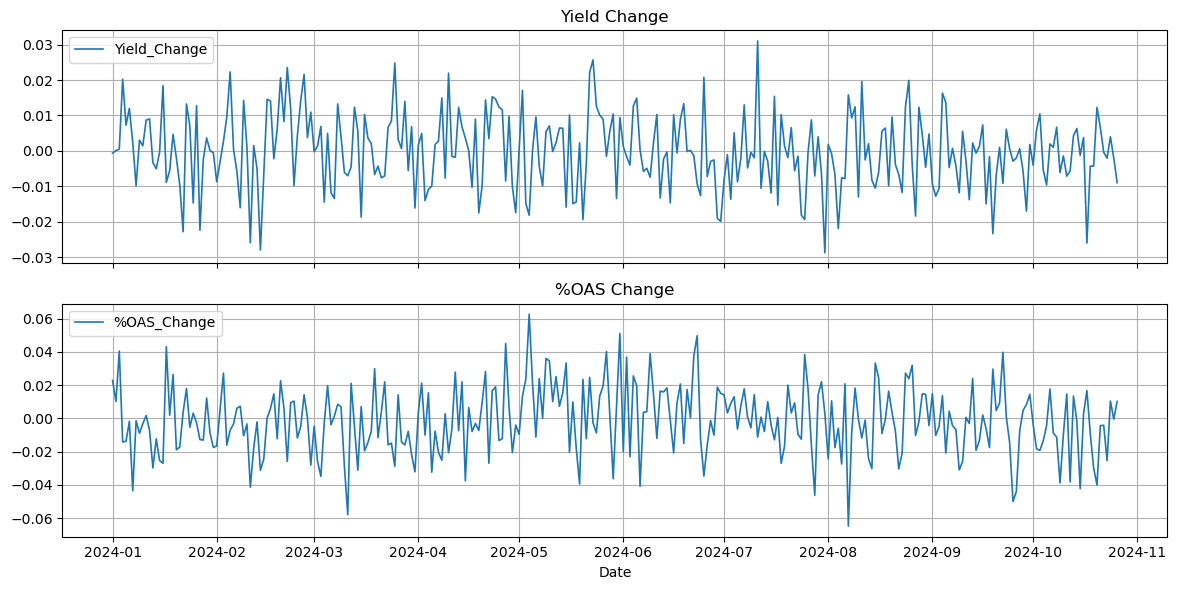

In [68]:
def compute_22day_rate_returns(yield_change_series: pd.Series) -> pd.Series:
    return yield_change_series.rolling(window=22).sum()

def plot_daily_factor_returns(daily_df: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    for i, col in enumerate(daily_df.columns):
        axes[i].plot(daily_df.index, daily_df[col], label=col, linewidth=1.2)
        axes[i].set_title(col.replace('_', ' '))
        axes[i].grid(True)
        axes[i].legend(loc='upper left')

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()

def run_cross_sectional_weighted_regressions(df: pd.DataFrame) -> pd.Series:
    coeffs = []
    for date, group in df.groupby('eff_date'):
        X = group['start_dts']
        y = group['22day_xs_rtn']
        w = group['weight']

        # Add constant for intercept
        X_design = sm.add_constant(X)
        model = sm.WLS(y, X_design, weights=w)
        result = model.fit()

        coeffs.append({'eff_date': date, 'beta_dts': result.params['start_dts']})

    return pd.DataFrame(coeffs).set_index('eff_date')['beta_dts']

def compute_ewma_covariance_longform(df: pd.DataFrame, half_life_days: int, min_obs: int = 60) -> pd.DataFrame:
    lambda_decay = 0.5 ** (1 / half_life_days)
    returns = df.dropna().copy()
    result_rows = []

    for end_idx in range(min_obs, len(returns)):
        end_date = returns.index[end_idx]
        window = returns.iloc[:end_idx + 1]  # up to and including end_idx
        X = window[::-1].to_numpy()  # reverse for correct decay order

        weights = np.array([lambda_decay ** i for i in range(len(X))])
        weights /= weights.sum()

        mean = np.average(X, axis=0, weights=weights)
        demeaned = X - mean
        cov = np.cov(demeaned.T, aweights=weights, bias=True)

        cov_df = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)
        cov_df['factor'] = cov_df.index
        cov_df['eff_date'] = end_date
        result_rows.append(cov_df.reset_index(drop=True))

    return pd.concat(result_rows, ignore_index=True)[['eff_date', 'factor'] + list(returns.columns)]

daily_df = pd.DataFrame({
    'Yield_Change': np.random.normal(0, 0.01, 300),
    '%OAS_Change': np.random.normal(0, 0.02, 300)
}, index=pd.date_range("2024-01-01", periods=300))
# Plot
plot_daily_factor_returns(daily_df)
ewma_covs = compute_ewma_covariance_longform(daily_df, half_life_days=252)

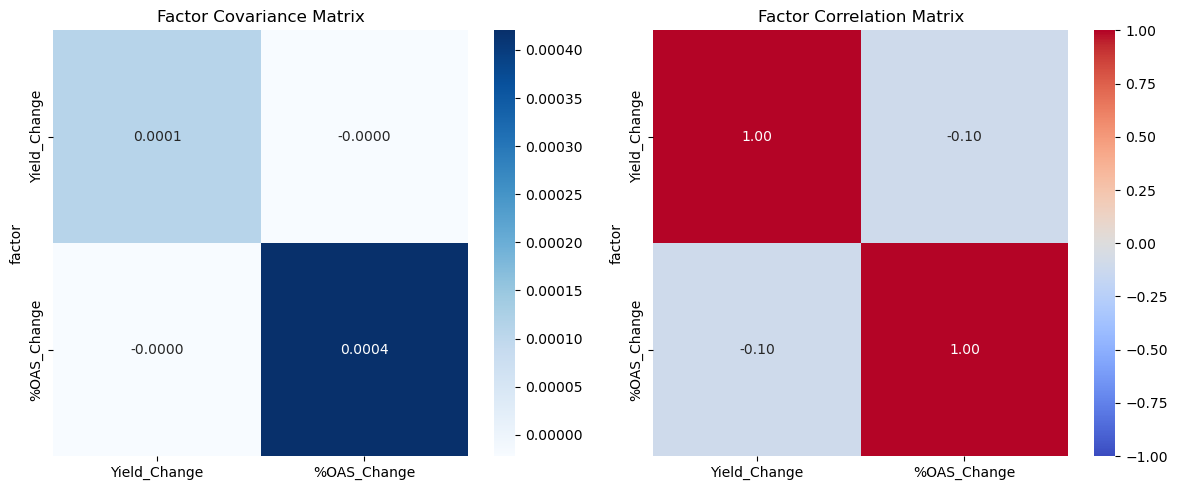

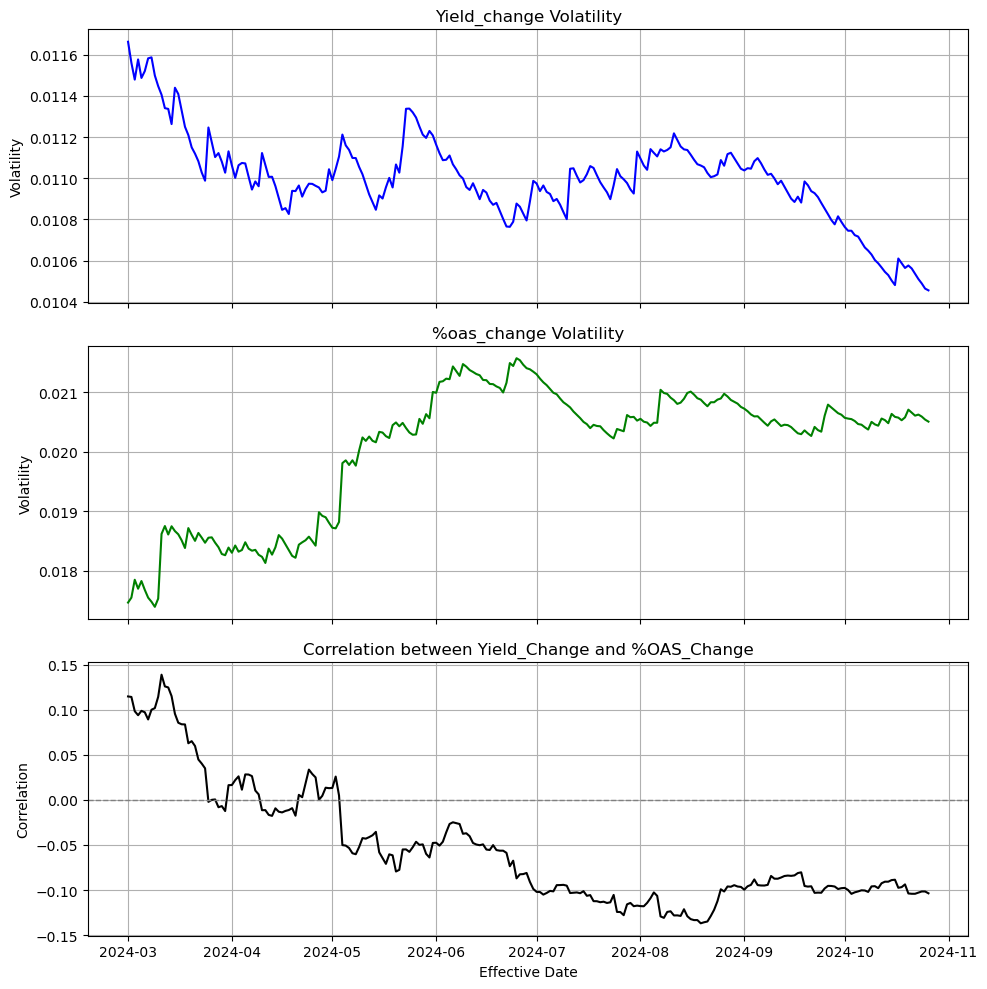

In [69]:
def plot_cov_and_corr_matrices(cov_matrix: pd.DataFrame, title_prefix: str = ""):
    """
    Plots the covariance and correlation matrices side by side using Seaborn.

    Parameters:
        cov_matrix (pd.DataFrame): Covariance matrix as a DataFrame (square, symmetric).
        title_prefix (str): Optional title prefix for the plots.
    """
    # Compute correlation matrix
    std_dev = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(std_dev, std_dev)
    corr_matrix = pd.DataFrame(corr_matrix, index=cov_matrix.index, columns=cov_matrix.columns)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cov_matrix, annot=True, fmt=".4f", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{title_prefix} Covariance Matrix")

    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title(f"{title_prefix} Correlation Matrix")

    plt.tight_layout()
    plt.show()


def plot_factor_vols_and_corr(covariance_df: pd.DataFrame):
    """
    Plots the volatilities of each factor and their correlation over time using 3 vertical subplots.

    Parameters:
        covariance_df (pd.DataFrame): Long-form DataFrame with columns:
            ['eff_date', 'factor', <factor1>, <factor2>, ...] — each row is a factor's covariance row.
    """
    # Ensure datetime type and sort
    covariance_df['eff_date'] = pd.to_datetime(covariance_df['eff_date'])
    covariance_df = covariance_df.sort_values(['eff_date', 'factor'])

    # Extract factor names (excluding 'eff_date' and 'factor')
    factor_names = [col for col in covariance_df.columns if col not in ['eff_date', 'factor']]
    if len(factor_names) != 2:
        raise ValueError("Function currently supports exactly 2 factors.")

    f1, f2 = factor_names

    records = []
    grouped = covariance_df.groupby('eff_date')
    for date, group in grouped:
        row = {'eff_date': date}
        for _, r in group.iterrows():
            row[f"var_{r['factor']}"] = r[r['factor']]
        # Grab off-diagonal covariance
        cov_f1_f2 = group.loc[group['factor'] == f1, f2].values[0]
        row['cov_f1_f2'] = cov_f1_f2
        records.append(row)

    df = pd.DataFrame(records).set_index('eff_date')
    df[f"vol_{f1}"] = np.sqrt(df[f"var_{f1}"])
    df[f"vol_{f2}"] = np.sqrt(df[f"var_{f2}"])
    df["corr"] = df["cov_f1_f2"] / (df[f"vol_{f1}"] * df[f"vol_{f2}"])

    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # Volatility plot for factor 1
    axes[0].plot(df.index, df[f"vol_{f1}"], label=f"{f1} Vol", color='blue')
    axes[0].set_title(f"{f1.capitalize()} Volatility")
    axes[0].set_ylabel("Volatility")
    axes[0].grid(True)

    # Volatility plot for factor 2
    axes[1].plot(df.index, df[f"vol_{f2}"], label=f"{f2} Vol", color='green')
    axes[1].set_title(f"{f2.capitalize()} Volatility")
    axes[1].set_ylabel("Volatility")
    axes[1].grid(True)

    # Correlation
    axes[2].plot(df.index, df["corr"], label="Correlation", color='black')
    axes[2].axhline(0, color='gray', linestyle='--', linewidth=1)
    axes[2].set_title(f"Correlation between {f1} and {f2}")
    axes[2].set_ylabel("Correlation")
    axes[2].set_xlabel("Effective Date")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

last_date = ewma_covs['eff_date'].max()
covar = ewma_covs[ewma_covs['eff_date'] == last_date].set_index('factor').drop(columns='eff_date')
plot_cov_and_corr_matrices(covar, title_prefix="Factor")
plot_factor_vols_and_corr(ewma_covs)


## Using Our Model
> Please note that all of the math below can also be computed using groups of factors or securities [which have factor exposures]. The examples use a two factor model for simplicity 

To compute **active risk** — the volatility of return differences between a portfolio and its benchmark — we use the factor exposures and the factor covariance matrix produced by our model.

In our two-factor setting, the "assets" are:

- The **rate factor** (e.g., duration-based exposure to Treasury yields),
- The **credit factor** (e.g., DTS-based exposure to credit spread changes).


---

### 1. Algebraic Expression: Active Risk for Two Risky Assets

Let:

- $B_{\text{rate}}$: active exposure to the rate factor (units: years of duration)  
- $B_{\text{credit}}$: active exposure to the credit factor (units: years × OAS in bps)  
- $\sigma_{\text{rate}}^2$: variance of rate factor returns (units: squared bps of yield)  
- $\sigma_{\text{credit}}^2$: variance of credit factor returns (units: squared bps of OAS)  
- $\sigma_{\text{rate,credit}}$: covariance between the two factor returns (units: bps of yield × bps of OAS)  

Then the **active risk** is given by:

$$
\text{Active Risk}^2 =
B_{\text{rate}}^2 \cdot \sigma_{\text{rate}}^2 +
B_{\text{credit}}^2 \cdot \sigma_{\text{credit}}^2 +
2 \cdot B_{\text{rate}} \cdot B_{\text{credit}} \cdot \sigma_{\text{rate,credit}}
$$

<span style="color:orange">This is the standard two-asset portfolio variance formula, where the "weights" are the active factor exposures.</span>



### 2. Matrix Form

Let the vector of active exposures be:

$$
B =
\begin{bmatrix}
B_{\text{rate}} & B_{\text{credit}}
\end{bmatrix}
$$

where:
- $B_{\text{rate}}$: active duration (units: years),
- $B_{\text{credit}}$: active DTS (units: years × OAS in bps).

Let the factor covariance matrix be:

$$
\Sigma_f =
\begin{bmatrix}
\sigma_{\text{rate}}^2 & \sigma_{\text{rate,credit}} \\
\sigma_{\text{rate,credit}} & \sigma_{\text{credit}}^2
\end{bmatrix}
$$

Then the active risk is:

$$
\text{Active Risk}^2 = B \cdot \Sigma_f \cdot B^\top
$$

$$
B \cdot \Sigma_f \cdot B^\top =
\begin{bmatrix}
B_{\text{rate}} & B_{\text{credit}}
\end{bmatrix}
\begin{bmatrix}
\sigma_{\text{rate}}^2 & \sigma_{\text{rate,credit}} \\
\sigma_{\text{rate,credit}} & \sigma_{\text{credit}}^2
\end{bmatrix}
\begin{bmatrix}
B_{\text{rate}} \\
B_{\text{credit}}
\end{bmatrix}
$$

Expanding:

$$
= B_{\text{rate}}^2 \cdot \sigma_{\text{rate}}^2 +
B_{\text{credit}}^2 \cdot \sigma_{\text{credit}}^2 +
2 \cdot B_{\text{rate}} \cdot B_{\text{credit}} \cdot \sigma_{\text{rate,credit}}
$$

This is identical to the algebraic active risk formula for two risky assets.

### Note: Deriving the Two-Asset Risk Formula

For a portfolio of two risky assets with weights $B_A$ and $B_B$, the portfolio return is:

$$
R_P = B_A \cdot R_A + B_B \cdot R_B
$$

The variance of the portfolio return is:

$$
\text{Var}(R_P) = E\left[(R_P - \mu_P)^2\right] =
E\left[\left(B_A \cdot (R_A - \mu_A) + B_B \cdot (R_B - \mu_B)\right)^2\right]
$$

Expanding the square:

$$
= B_A^2 \cdot E[(R_A - \mu_A)^2] +
B_B^2 \cdot E[(R_B - \mu_B)^2] +
2 \cdot B_A \cdot B_B \cdot E[(R_A - \mu_A)(R_B - \mu_B)]
$$

Which simplifies to:

$$
\text{Var}(R_P) =
B_A^2 \cdot \sigma_A^2 +
B_B^2 \cdot \sigma_B^2 +
2 \cdot B_A \cdot B_B \cdot \sigma_{AB}
$$

This matches the algebraic structure we use for **active risk**, where $B_A$ and $B_B$ represent **active factor exposures** (e.g., active duration and active DTS), and $\sigma^2$, $\sigma_{AB}$ are computed from factor return history.





### A couple of common risk calculations

### Standalone Risk (Called SAC or SAR)

**Standalone risk** measures how much active risk a single factor contributes **on its own**, assuming all other active exposures are zero.

It can be expressed two ways:

$$
\text{Standalone Risk}_i^2 = B_i \cdot \sigma_i^2 \cdot B_i = B_i^2 \cdot \sigma_i^2
$$

$$
\text{Standalone Risk}_i = |B_i| \cdot \sqrt{\sigma_i^2}
$$

Where:
- $B_i$ = active exposure to factor $i$
- $\sigma_i^2$ = **annualized variance** of the factor return

---

Standalone risk approximates what you’d expect to see on a year-end attribution report.


### Example Calculation of SAC / SAR

All volatilities below are **per year**.

$$
\begin{array}{|c|c|c|c|}
\hline
\textbf{Factor} & \textbf{Active Exposure } B_i & \textbf{Volatility } \sqrt{\sigma_i^2} & \textbf{Standalone Risk (bps/year)} \\
\hline
\text{Rate (Duration)} & 0.5 \text{ yrs} & 90 \text{ bps} & 0.5 \cdot 90 = 45 \\
\text{Credit (DTS)} & -20 & 36\% \text{ of OAS} & |-20| \cdot .36 = 7.2 \\
\hline
\end{array}
$$

---

### Notes:
- **Rate volatility** is the annualized standard deviation of yield changes (in bps).
- **Credit volatility** is the annualized standard deviation of percent OAS changes (e.g., if OAS = 100 bps, then 36% = 36 bps).
- These are **univariate risks** — they do not account for correlation or interaction with other factors.


### Contribution to Active Risk (CAR)

We define total active risk as:

$$
\text{AR} = \sqrt{B \cdot \Sigma_f \cdot B^\top}
$$

To compute the contribution from factor $i$, we use:

$$
\text{CAR}_i = \frac{B_i \cdot (\Sigma_f \cdot B^\top)_i}{\text{AR}}
$$

The term $(\Sigma_f \cdot B^\top)_i$ represents the covariance between factor $i$ and the portfolio’s active return. Multiplying by $B_i$ gives the portion of active **variance** attributable to factor $i$. Dividing by $\text{AR}$ converts it to a contribution to **volatility**, which we interpret as $\text{CAR}_i$ — the amount of total tracking error explained by that factor.

#### Simple Derivation of the CAR Formula

We begin with total active risk:

$$
\text{AR} = \sqrt{B \cdot \Sigma_f \cdot B^\top}
$$

Squaring both sides gives total active variance:

$$
\text{AR}^2 = B \cdot \Sigma_f \cdot B^\top = \sum_{i=1}^{K} \sum_{j=1}^{K} B_i \cdot B_j \cdot (\Sigma_f)_{ij}
$$

We want to isolate the portion of this variance attributable to factor $i$. Focusing on the terms in the double sum that involve $B_i$:

$$
\sum_{j=1}^{K} B_i \cdot B_j \cdot (\Sigma_f)_{ij} = B_i \cdot \sum_{j=1}^{K} B_j \cdot (\Sigma_f)_{ij}
$$

This is exactly the $i$-th element of the matrix-vector product:

$$
(\Sigma_f \cdot B^\top)_i = \sum_{j=1}^{K} (\Sigma_f)_{ij} \cdot B_j
$$

So the total **variance** contribution from factor $i$ is:

$$
B_i \cdot (\Sigma_f \cdot B^\top)_i
$$

To express this as a contribution to total **volatility** (i.e., active risk), we divide by $\text{AR}$:

$$
\text{CAR}_i = \frac{B_i \cdot (\Sigma_f \cdot B^\top)_i}{\text{AR}}
$$

This gives the contribution to total active risk (in bps/year) attributable to factor $i$.


---

### Example Calculation of CAR 

Given:
- $B = \begin{bmatrix} 0.5 & -20 \end{bmatrix}$
- $\sqrt{\sigma^2_{\text{rate}}} = 90$, so $\sigma^2_{\text{rate}} = 8100$
- $\sqrt{\sigma^2_{\text{credit}}} = 0.36$, so $\sigma^2_{\text{credit}} = 0.1296$
- $\rho = -0.2$, so $\text{Cov}_{\text{rate, credit}} = -0.2 \cdot 90 \cdot 0.36 = -6.48$

The covariance matrix:

$$
\Sigma_f =
\begin{bmatrix}
8100 & -6.48 \\
-6.48 & 0.1296
\end{bmatrix}, \quad
B^\top =
\begin{bmatrix}
0.5 \\
-20
\end{bmatrix}
$$

Compute:

$$
\Sigma_f \cdot B^\top =
\begin{bmatrix}
4179.6 \\
-5.832
\end{bmatrix}
$$

Then:

$$
\text{AR}^2 = 0.5 \cdot 4179.6 + (-20) \cdot (-5.832) = 2206.44, \quad \text{AR} = \sqrt{2206.44} \approx 46.98
$$


All risk values are in bps/year. Please note that CAR must sum to total active risk

$$
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Factor} & B_i & (\Sigma_f \cdot B^\top)_i & \text{AR} & \text{CAR}_i \\
\hline
\text{Rate (Duration)} & 0.5 & 4179.6 & 46.98 & \frac{0.5 \cdot 4179.6}{46.98} = 44.5 \\
\text{Credit (DTS)} & -20 & -5.832 & 46.98 & \frac{-20 \cdot (-5.832)}{46.98} = 2.5 \\
\hline
\end{array}
$$



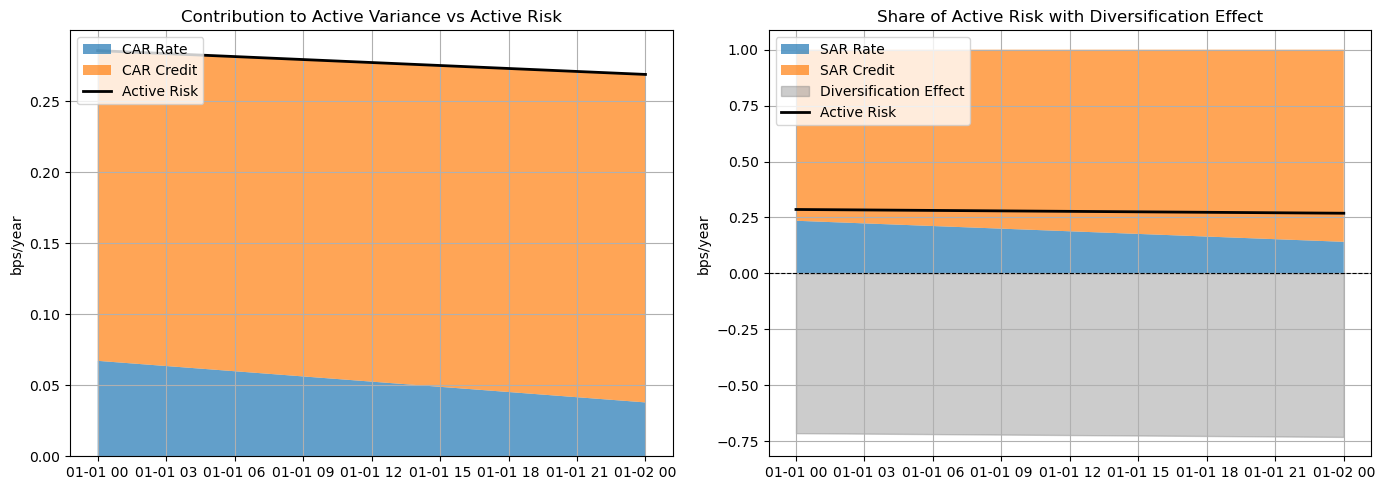

In [ ]:
def compute_active_risk_car_sar(beta_df: pd.DataFrame, covariance_df: pd.DataFrame):
    results = []

    for eff_date, beta_row in beta_df.iterrows():
        beta = beta_row.values  # β vector [1×K]
        factor_names = beta_row.index.tolist()

        # Extract and reorder the covariance matrix
        cov_slice = covariance_df[covariance_df['eff_date'] == eff_date]
        cov_slice = cov_slice.set_index('factor').loc[factor_names]
        Sigma = cov_slice[factor_names].values  # Σ matrix [K×K]

        # Compute active variance and active risk
        active_var = beta @ Sigma @ beta.T
        active_risk = np.sqrt(active_var)

        # Compute Σβ
        sigma_beta = Sigma @ beta  # [K×1]

        # Compute CAR and SAR
        car = (beta * sigma_beta) / active_risk  # [1×K]
        sar = car / active_risk if active_risk > 0 else np.zeros_like(car)

        row = {'eff_date': eff_date, 'active_risk': active_risk}
        row.update({f'CAR_{f}': c for f, c in zip(factor_names, car)})
        row.update({f'SAR_{f}': s for f, s in zip(factor_names, sar)})
        results.append(row)

    return pd.DataFrame(results).set_index('eff_date')


def plot_active_risk_decomposition(risk_df: pd.DataFrame):
    # Ensure chronological order
    risk_df = risk_df.sort_index()

    dates = risk_df.index
    active_risk = risk_df['active_risk']
    car_rate = risk_df['CAR_rate']
    car_credit = risk_df['CAR_credit']
    sar_rate = risk_df['SAR_rate']
    sar_credit = risk_df['SAR_credit']

    # Total SAR and diversification effect
    sar_total = sar_rate + sar_credit
    diversification_effect = -(sar_total - active_risk)  # now negative

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    # --- Left: CARs + Active Risk ---
    ax1 = axes[0]
    ax1.stackplot(
        dates, car_rate, car_credit,
        labels=['CAR Rate', 'CAR Credit'],
        alpha=0.7
    )
    ax1.plot(dates, active_risk, color='black', linewidth=2, label='Active Risk')
    ax1.set_title('Contribution to Active Variance vs Active Risk')
    ax1.set_ylabel('bps/year')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # --- Right: SARs + Diversification Effect ---
    ax2 = axes[1]
    ax2.stackplot(
        dates, sar_rate, sar_credit,
        labels=['SAR Rate', 'SAR Credit'],
        alpha=0.7
    )
    # Plot diversification effect as negative area
    ax2.fill_between(
        dates,
        0,
        diversification_effect,
        where=(diversification_effect < 0),
        color='grey',
        alpha=0.4,
        label='Diversification Effect'
    )
    # Also plot active risk as black line
    ax2.plot(dates, active_risk, color='black', linewidth=2, label='Active Risk')
    ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax2.set_title('Share of Active Risk with Diversification Effect')
    ax2.set_ylabel('bps/year')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


beta_df = pd.DataFrame({
    'rate': [0.6, 0.4],
    'credit': [0.8, 0.9]
}, index=pd.to_datetime(['2024-01-01', '2024-01-02']))


covariance_df['eff_date'] = pd.to_datetime(covariance_df['eff_date'])

risk_df = compute_active_risk_car_sar(beta_df, covariance_df)
plot_active_risk_decomposition(risk_df)
